#**Problem statement:**

#### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [3]:
!pip install -q tensorFlow

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [9]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/SkinCancer_ISIC_Data/Test')

In [10]:
# delete output folder from subdirectories of data_dir_train

import os
import shutil

def delete_output_folders(data_dir):
  for root, dirs, files in os.walk(data_dir):
    for dir_name in dirs:
      if dir_name == "output":
        dir_path = os.path.join(root, dir_name)
        try:
          shutil.rmtree(dir_path)
          print(f"Deleted output folder: {dir_path}")
        except OSError as e:
          print(f"Error deleting output folder {dir_path}: {e}")

delete_output_folders(data_dir_train)

Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/pigmented benign keratosis/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/basal cell carcinoma/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/vascular lesion/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/melanoma/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/actinic keratosis/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/seborrheic keratosis/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/dermatofibroma/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/nevus/output
Deleted output folder: /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/squamous cell carcinoma/output


In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [16]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

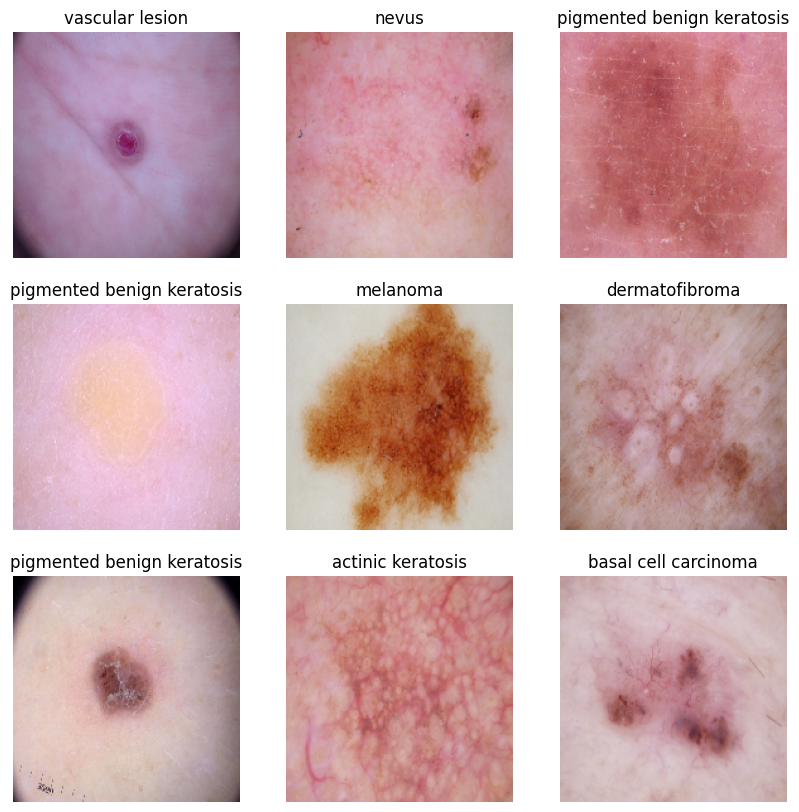

In [17]:
import matplotlib.pyplot as plt
import random
from skimage import io

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### **Create the model**
 Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [20]:
# CNN Model
model1= Sequential()
# scaling the pixel values from 0-255 to 0-1
model1.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model1.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model1.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model1.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model1.add(layers.MaxPooling2D())

model1.add(layers.Flatten())
model1.add(layers.Dense(256,activation='relu'))
model1.add(layers.Dense(9,activation='softmax'))

### **Compile the model**
Choose an appropirate optimiser and loss function for model training

In [21]:
# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### **Train the model**

In [22]:
# Train the model with epochs
epochs=20 #@param {type:"integer"}
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.1946 - loss: 6.1076 - val_accuracy: 0.4273 - val_loss: 1.6835
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 65ms/step - accuracy: 0.4123 - loss: 1.6524 - val_accuracy: 0.3870 - val_loss: 1.6070
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4863 - loss: 1.4490 - val_accuracy: 0.5235 - val_loss: 1.3928
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5406 - loss: 1.2959 - val_accuracy: 0.5213 - val_loss: 1.4118
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.5864 - loss: 1.1929 - val_accuracy: 0.5302 - val_loss: 1.3912
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.6177 - loss: 1.0499 - val_accuracy: 0.5257 - val_loss: 1.4930
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6508 - loss: 0.9436 - val_accuracy: 0.5302 - val_loss: 1.5321
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6999 - loss: 0.8422 - val_accuracy: 0.5347 - 

### **Visualizing training results**

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

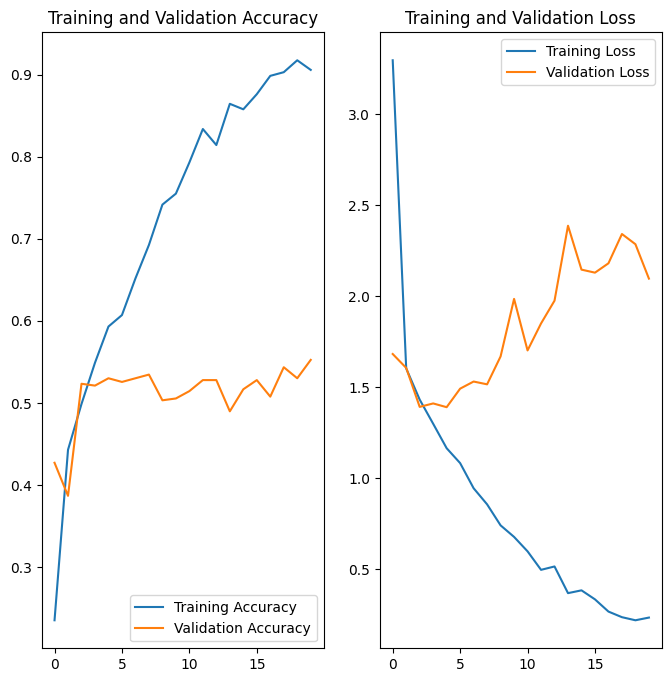

In [23]:
plot_cnn_metrics(history,epochs)

### **Findings :**
1. The training accuracy increases linearly with number of epochs, whereas the validation accuracy stabilizes at ~50% accuracy after this model fit.
2. The training loss decreases with number of epochs, while the validation loss increases.
3. The plots show that training accuracy (~92%) and validation accuracy differ by large margins, and the model has achieved ~50% accuracy on the validation set.
4. The significant difference in accuracy between training and validation is a **sign of overfitting**.

### Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are less number of training examples. Data augmentation takes the approach of generating additional training data from existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

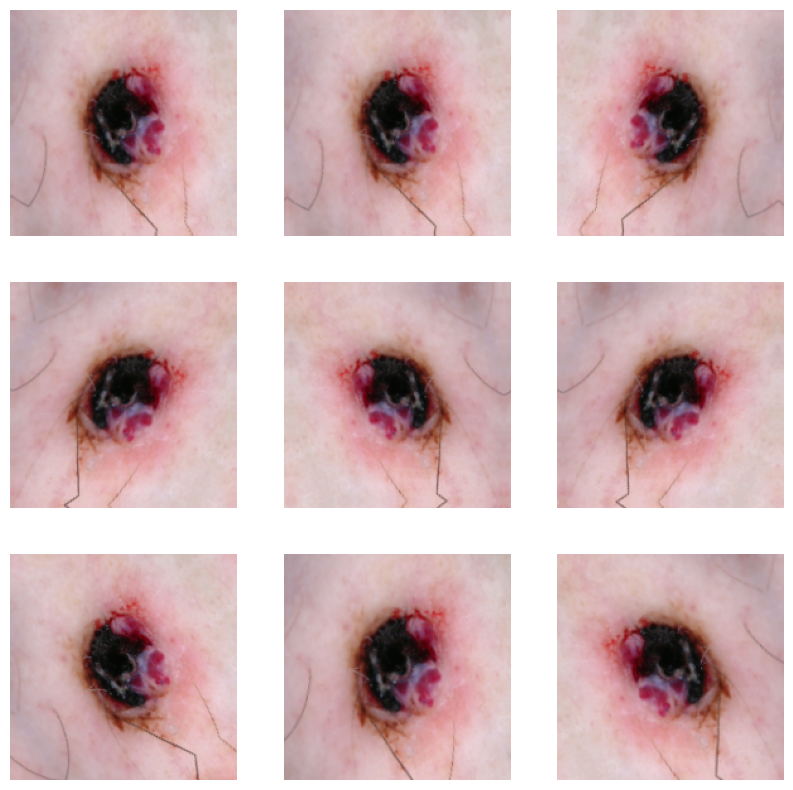

In [25]:
# visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### **Model Building & training on the augmented data :**
1.   Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2.   Choosing an appropriate optimiser and loss function for model training
3.  Training the model for ~20 epochs
4.  Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [26]:
# CNN Model
model2=Sequential()
# scaling the pixel values from 0-255 to 0-1
model2.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model2.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model2.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model2.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model2.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model2.add(layers.MaxPooling2D())

model2.add(layers.Flatten())
model2.add(layers.Dense(256,activation='relu'))
model2.add(layers.Dense(9,activation='softmax'))

In [27]:
# Compiling the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Training the model
epochs=20 #@param {type:"integer"}
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.1740 - loss: 6.5415 - val_accuracy: 0.2595 - val_loss: 1.9564
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.2620 - loss: 1.9690 - val_accuracy: 0.3266 - val_loss: 1.8122
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.3526 - loss: 1.8023 - val_accuracy: 0.4004 - val_loss: 1.7522
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.4070 - loss: 1.6080 - val_accuracy: 0.4855 - val_loss: 1.5536
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.4684 - loss: 1.5241 - val_accuracy: 0.5123 - val_loss: 1.4801
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.4924 - loss: 1.4258 - val_accuracy: 0.5101 - val_loss: 1.5257
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.4987 - loss: 1.4315 - val_accuracy: 0.4765 - val_loss: 1.5185
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5359 - loss: 1.3474 - val_accuracy: 0.503

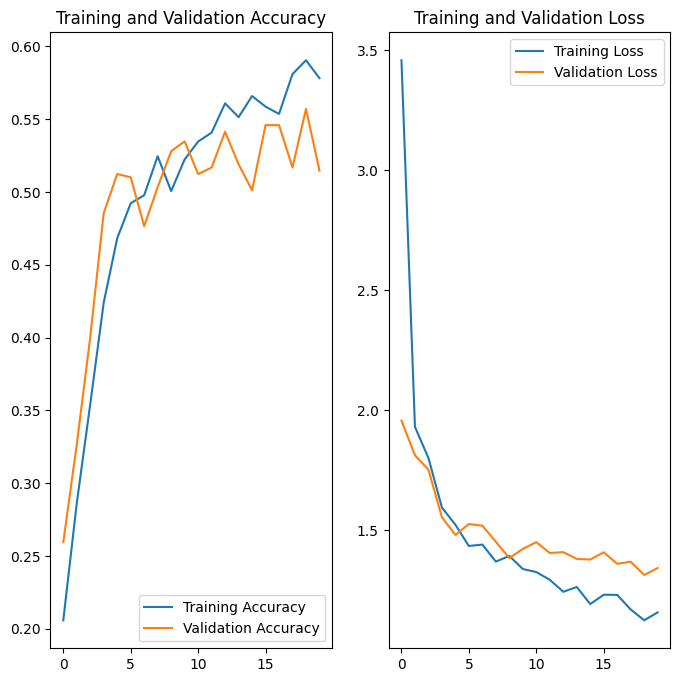

In [29]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

### **Findings** :

1. Till 10 epochs, training accuracy increases rapidly and then it increases at a lower rate with the number of epochs, whereas the validation accuracy increases and becomes stagnant around 55%.

2.  Training loss shows decreasing trend with epochs but the validation loss decreases and stalls around 1.3.

3.  The plots show that gap between training accuracy and validation accuracy has decreased from previous model, and it has achieved around 55% accuracy on the validation set.

4.  The difference in accuracy between training and validation accuracy is still slightly noticeable which is a sign of overfitting.

### Model Building & training **on the Augmented data with Dropout** :
1. Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2. Choosing an appropriate optimiser and loss function for model training
Training the model for ~20 epochs
3. Plotting Graph after the model fit to check if there is any evidence of model overfit or underfit.

In [30]:
# CNN Model
model3=Sequential()
# scaling the pixel values from 0-255 to 0-1
model3.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model3.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model3.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model3.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model3.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model3.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model3.add(layers.Dropout(0.2))

model3.add(layers.Flatten())
model3.add(layers.Dense(256,activation='relu'))
model3.add(layers.Dense(9,activation='softmax'))

In [31]:
# Compiling the model
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Training the model
epochs=20 #@param {type:"integer"}
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.1943 - loss: 8.8195 - val_accuracy: 0.2573 - val_loss: 2.0620
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.2534 - loss: 2.0145 - val_accuracy: 0.3020 - val_loss: 1.8606
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.2789 - loss: 1.9185 - val_accuracy: 0.3378 - val_loss: 1.7821
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.3547 - loss: 1.7468 - val_accuracy: 0.2998 - val_loss: 1.7831
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.3880 - loss: 1.6829 - val_accuracy: 0.3893 - val_loss: 1.9236
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.3916 - loss: 1.6934 - val_accuracy: 0.4743 - val_loss: 1.5246
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.3947 - loss: 1.6567 - val_accuracy: 0.4832 - val_loss: 1.5434
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.4587 - loss: 1.4972 - val_accuracy:

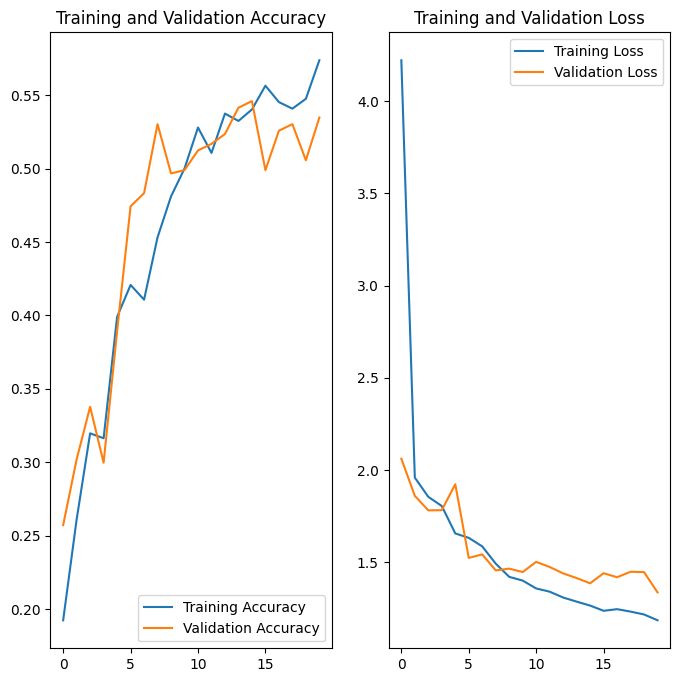

In [33]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

### **Findings :**
1.  Till 10 epochs, training accuracy increases rapidly and then it increases at a lower rate with the number of epochs, whereas the validation accuracy increases and becomes stagnant between 50%-55%.
2.  Training loss shows decreasing trend with epochs but the validation loss decreases and stalls around 1.3.
3.  The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
4.  The difference in accuracy between training and validation accuracy is very less.

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

### **Class distribution:**
Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Visualize distribution of classes in the training dataset.

In [34]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Images'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Images
0,pigmented benign keratosis,462
1,basal cell carcinoma,376
2,vascular lesion,139
3,melanoma,438
4,actinic keratosis,114
5,seborrheic keratosis,77
6,dermatofibroma,95
7,nevus,357
8,squamous cell carcinoma,181


<Axes: xlabel='No. of Images', ylabel='Class'>

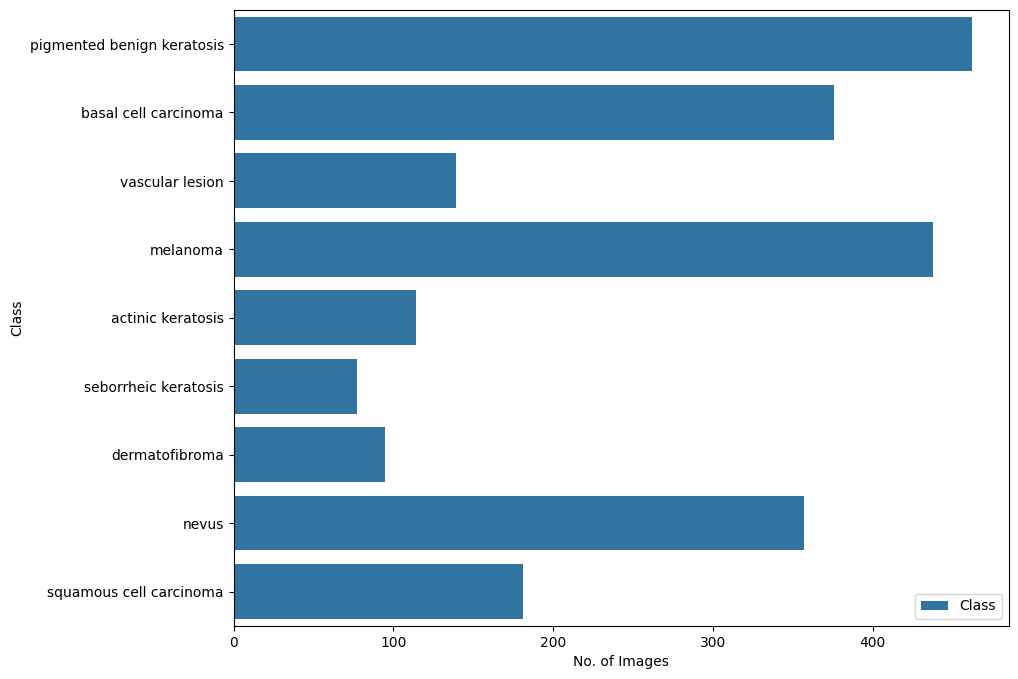

In [35]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Images", y="Class", data=df,
            label="Class")

### **Findings :**
Which class has the least number of samples?

seborrheic keratosis with 77 samples

Which classes dominate the data in terms proportionate number of samples?

pigmented benign keratosis with 462 samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
#install Augmentor
!pip install -q Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [37]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7EC438D1E0>: 100%|██████████| 500/500 [00:23<00:00, 21.34 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7EC45D4E80>: 100%|██████████| 500/500 [00:20<00:00, 24.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7EC4642920>: 100%|██████████| 500/500 [00:19<00:00, 25.50 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A7EBE938400>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7F3FFAB550>: 100%|██████████| 500/500 [01:23<00:00,  6.00 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7EBEDA9150>: 100%|██████████| 500/500 [00:20<00:00, 23.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A7EBEDABD00>: 100%|██████████| 500/500 [00:38<00:00, 13.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7EBEDA9150>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A7EBEDABD00>: 100%|██████████| 500/500 [00:18<00:00, 26.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
import os
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [40]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = lesion_list_new.append(df2)
# new_df = pd.concat([df2, pd.DataFrame(lesion_list_new, columns=['Label'])], ignore_index=True)

In [42]:
df2['Label'].value_counts()

,count
Label,
pigmented benign keratosis,500
basal cell carcinoma,500
vascular lesion,500
melanoma,500
actinic keratosis,500
seborrheic keratosis,500
dermatofibroma,500
nevus,500
squamous cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor


In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
data_dir_train = '/content/gdrive/MyDrive/SkinCancer_ISIC_Data/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [45]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### **Model Building & training on the rectified class imbalance data :**
1. Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
2. Choosing an appropriate optimiser and loss function for model training
Training the model for ~30 epochs
3. Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [46]:
# CNN Model
model=Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [47]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
# Training the model
epochs=30 #@param {type:"integer"}
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 53s 286ms/step - accuracy: 0.2263 - loss: 2.6584 - val_accuracy: 0.3816 - val_loss: 1.6429
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 268ms/step - accuracy: 0.3828 - loss: 1.6004 - val_accuracy: 0.4217 - val_loss: 1.5123
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 260ms/step - accuracy: 0.4504 - loss: 1.4568 - val_accuracy: 0.4774 - val_loss: 1.3366
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 277ms/step - accuracy: 0.4676 - loss: 1.3711 - val_accuracy: 0.5182 - val_loss: 1.2477
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - accuracy: 0.5006 - loss: 1.2813 - val_accuracy: 0.5419 - val_loss: 1.2110
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 255ms/step - accuracy: 0.5254 - loss: 1.2339 - val_accuracy: 0.5494 - val_loss: 1.1611
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 269ms/step - accuracy: 0.5437 - loss: 1.2057 - val_accuracy: 0.5887 - val_loss: 1.0889
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 268ms/step - accuracy: 0.5737 - loss: 1

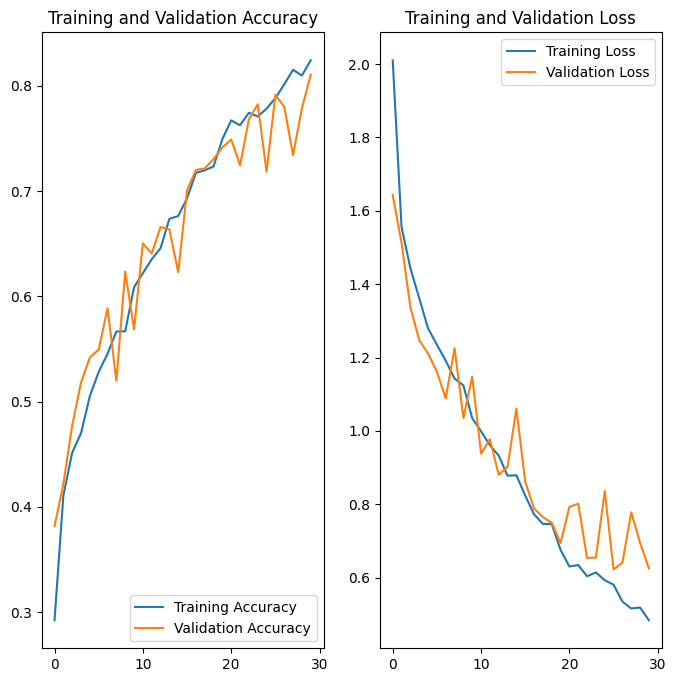

In [49]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

### **Findings :**
1.   Training accuracy and validation accuracy, both increase almost linearly with number of epochs.
2.  The training loss and validation loss both decrease with number of epochs.
3.  The plots show that gap between training accuracy and validation accuracy have decreased significantly as compared to the previous models, and they almost overlap. This model has achieved around 75-80% accuracy on the validation set.
4.  The difference in accuracy between training and validation accuracy is very less, which indicates now there no or very less overfitting.

**Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 75%.**